PREDICT CREDIT ACCEPTANCE
- Mencegah menolak pengguna credit yang tidak gagal bayar (Target =0) dan mencegah menerima pengguna credit yang dapat gagal bayar (Target = 1).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix,classification_report
from IPython.display import display
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import plot_confusion_matrix
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [2]:
datatrain = pd.read_csv('application_train.csv')
datatest = pd.read_csv('application_test.csv')
bureau = pd.read_csv('bureau.csv')
ccb = pd.read_csv('credit_card_balance.csv')
ins = pd.read_csv('installments_payments.csv')
pos = pd.read_csv('POS_CASH_BALANCE.csv')
prev =pd.read_csv('previous_application.csv')

In [3]:
import warnings                                 # Used to ignore the warning given as output of the code
warnings.filterwarnings('ignore')

DATA EXPLORATION, DATA PREPROCESSING

In [4]:
print(datatrain.shape)
print(bureau.shape)
print(ccb.shape)
print(ins.shape)
print(pos.shape)
print(prev.shape)

(307511, 75)
(1716428, 17)
(3840312, 23)
(13605401, 8)
(10001358, 8)
(1670214, 37)


In [5]:
datatrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   307511 non-null  int64  
 1   TARGET                       307511 non-null  int64  
 2   NAME_CONTRACT_TYPE           307511 non-null  object 
 3   CODE_GENDER                  307511 non-null  object 
 4   FLAG_OWN_CAR                 307511 non-null  object 
 5   FLAG_OWN_REALTY              307511 non-null  object 
 6   CNT_CHILDREN                 307511 non-null  int64  
 7   AMT_INCOME_TOTAL             307511 non-null  float64
 8   AMT_CREDIT                   307511 non-null  float64
 9   AMT_ANNUITY                  307499 non-null  float64
 10  AMT_GOODS_PRICE              307233 non-null  float64
 11  NAME_TYPE_SUITE              306219 non-null  object 
 12  NAME_INCOME_TYPE             307511 non-null  object 
 13 

In [6]:
datatrain.duplicated().sum()

0

Tidak ada data berulang

In [7]:
datatrain=datatrain.drop(['SK_ID_CURR'],axis =1)
datatest=datatest.drop(['SK_ID_CURR'],axis =1)

In [8]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


<AxesSubplot:xlabel='DAYS_CREDIT', ylabel='Count'>

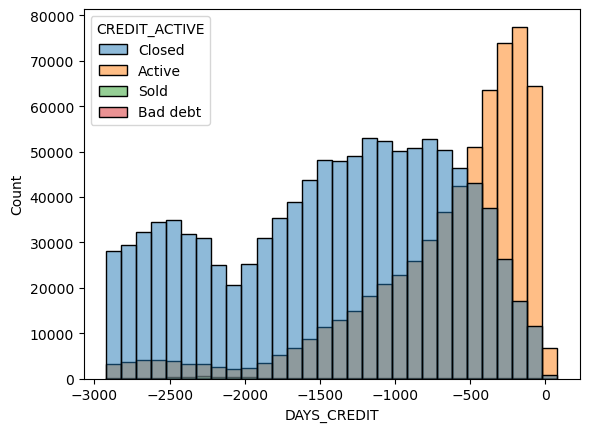

In [9]:
sns.histplot(data =bureau, x='DAYS_CREDIT',hue ='CREDIT_ACTIVE', binwidth= 100)

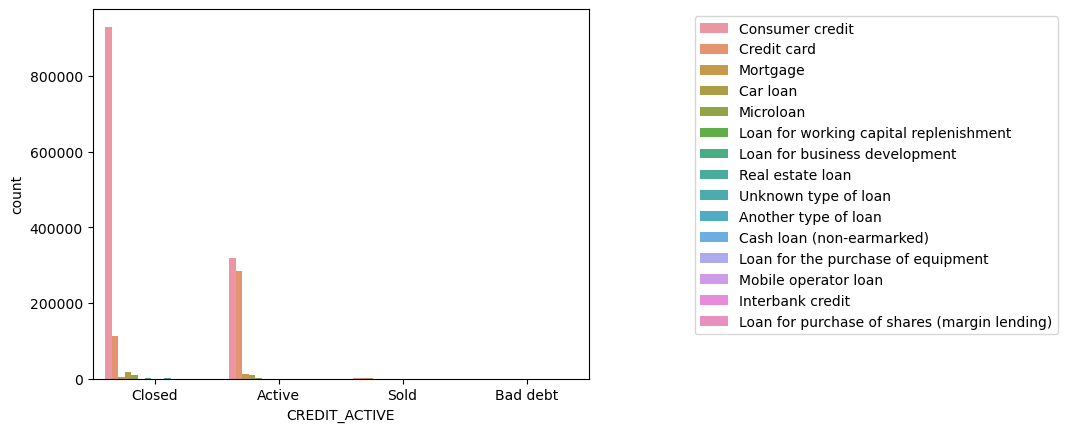

In [10]:
credac=sns.countplot(data = bureau, x='CREDIT_ACTIVE', hue ='CREDIT_TYPE')
credac.legend(bbox_to_anchor= (1.2,1))

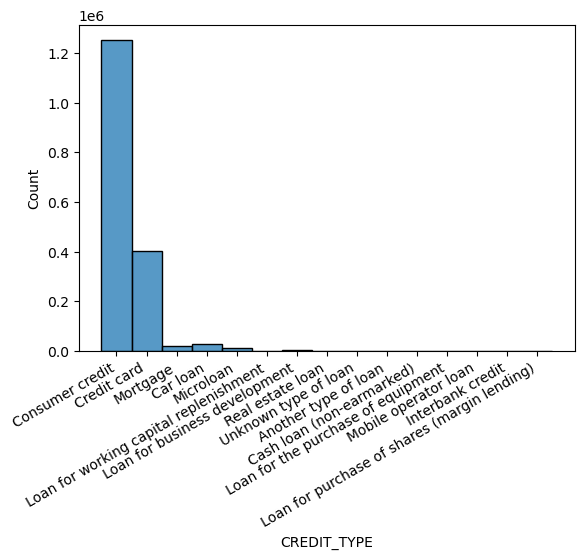

In [11]:
fig,ax = plt.subplots()
sns.histplot(data=bureau, x='CREDIT_TYPE')
fig.autofmt_xdate()

In [12]:
pos.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [13]:
ins.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [14]:
ccb.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [15]:
prev.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
def stacked_barplot(data,predictor,target,figsize=(10,6)):
  (pd.crosstab(data[predictor],data[target],normalize='index')*100).plot(kind='bar',figsize=figsize,stacked=True)
  plt.legend(loc="lower right")
  plt.ylabel('Persentase setiap status kontrak %')

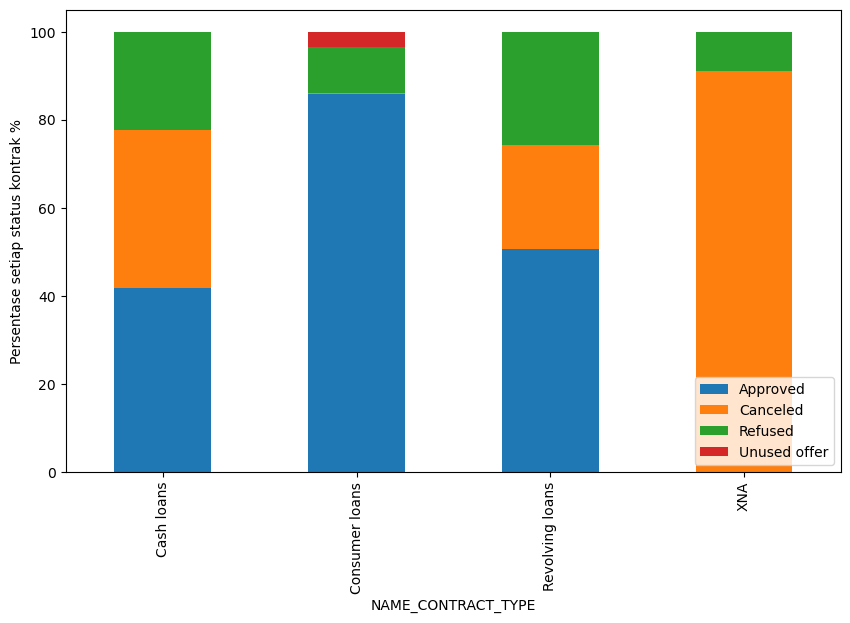

In [17]:
stacked_barplot(prev,'NAME_CONTRACT_TYPE','NAME_CONTRACT_STATUS')

Sebagian besar dari tipe kontrak yang tidak teridentifikasi (XNA) telah ditolak

In [18]:
datatrain.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


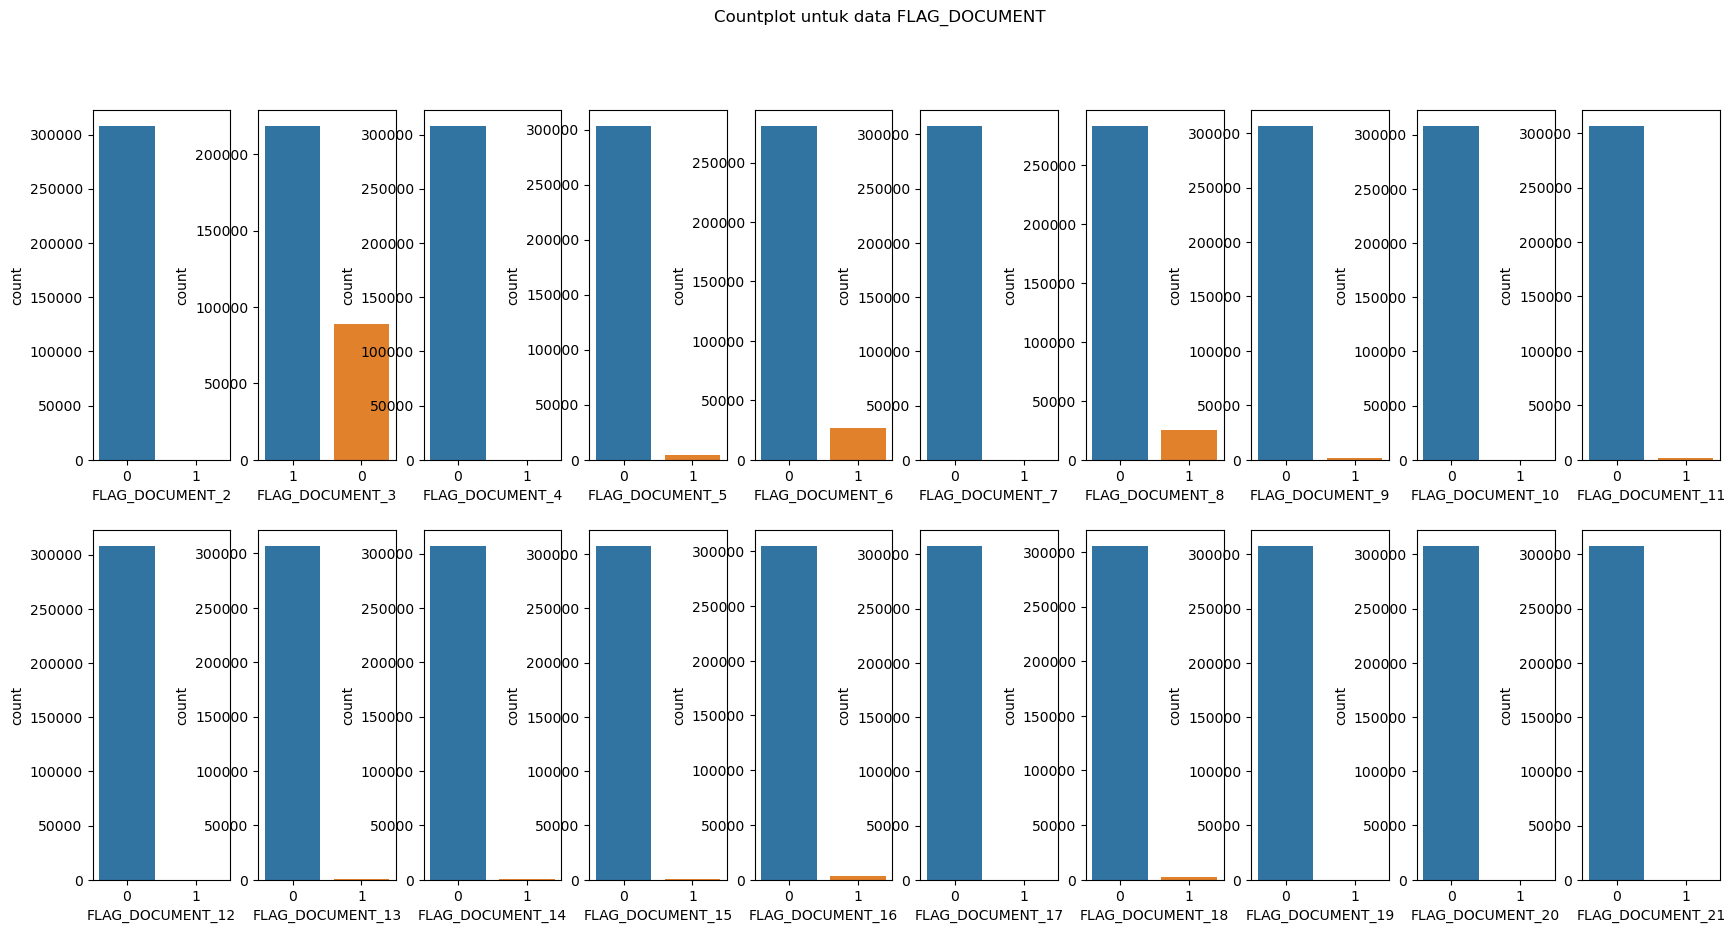

In [19]:
#Observasi fitur FLAG_DOCUMENT
fig,axes = plt.subplots(2,10,figsize =(21,10))
fig.suptitle('Countplot untuk data FLAG_DOCUMENT')
sns.countplot(ax = axes[0,0], x = 'FLAG_DOCUMENT_2',data = datatrain, order = datatrain['FLAG_DOCUMENT_2'].value_counts().index);
sns.countplot(ax = axes[0,1], x = 'FLAG_DOCUMENT_3',data = datatrain, order = datatrain['FLAG_DOCUMENT_3'].value_counts().index);
sns.countplot(ax = axes[0,2], x = 'FLAG_DOCUMENT_4',data = datatrain, order = datatrain['FLAG_DOCUMENT_4'].value_counts().index);
sns.countplot(ax = axes[0,3], x = 'FLAG_DOCUMENT_5',data = datatrain, order = datatrain['FLAG_DOCUMENT_5'].value_counts().index);
sns.countplot(ax = axes[0,4], x = 'FLAG_DOCUMENT_6',data = datatrain, order = datatrain['FLAG_DOCUMENT_6'].value_counts().index);
sns.countplot(ax = axes[0,5], x = 'FLAG_DOCUMENT_7',data = datatrain, order = datatrain['FLAG_DOCUMENT_7'].value_counts().index);
sns.countplot(ax = axes[0,6], x = 'FLAG_DOCUMENT_8',data = datatrain, order = datatrain['FLAG_DOCUMENT_8'].value_counts().index);
sns.countplot(ax = axes[0,7], x = 'FLAG_DOCUMENT_9',data = datatrain, order = datatrain['FLAG_DOCUMENT_9'].value_counts().index);
sns.countplot(ax = axes[0,8], x = 'FLAG_DOCUMENT_10',data = datatrain, order = datatrain['FLAG_DOCUMENT_10'].value_counts().index);
sns.countplot(ax = axes[0,9], x = 'FLAG_DOCUMENT_11',data = datatrain, order = datatrain['FLAG_DOCUMENT_11'].value_counts().index);
sns.countplot(ax = axes[1,0], x = 'FLAG_DOCUMENT_12',data = datatrain, order = datatrain['FLAG_DOCUMENT_12'].value_counts().index);
sns.countplot(ax = axes[1,1], x = 'FLAG_DOCUMENT_13',data = datatrain, order = datatrain['FLAG_DOCUMENT_13'].value_counts().index);
sns.countplot(ax = axes[1,2], x = 'FLAG_DOCUMENT_14',data = datatrain, order = datatrain['FLAG_DOCUMENT_14'].value_counts().index);
sns.countplot(ax = axes[1,3], x = 'FLAG_DOCUMENT_15',data = datatrain, order = datatrain['FLAG_DOCUMENT_15'].value_counts().index);
sns.countplot(ax = axes[1,4], x = 'FLAG_DOCUMENT_16',data = datatrain, order = datatrain['FLAG_DOCUMENT_16'].value_counts().index);
sns.countplot(ax = axes[1,5], x = 'FLAG_DOCUMENT_17',data = datatrain, order = datatrain['FLAG_DOCUMENT_17'].value_counts().index);
sns.countplot(ax = axes[1,6], x = 'FLAG_DOCUMENT_18',data = datatrain, order = datatrain['FLAG_DOCUMENT_18'].value_counts().index);
sns.countplot(ax = axes[1,7], x = 'FLAG_DOCUMENT_19',data = datatrain, order = datatrain['FLAG_DOCUMENT_19'].value_counts().index);
sns.countplot(ax = axes[1,8], x = 'FLAG_DOCUMENT_20',data = datatrain, order = datatrain['FLAG_DOCUMENT_20'].value_counts().index);
sns.countplot(ax = axes[1,9], x = 'FLAG_DOCUMENT_21',data = datatrain, order = datatrain['FLAG_DOCUMENT_21'].value_counts().index);


- FLAG_DOCUMENT_2,4,7,9,10,12,13,14,15,17,19,20,21 akan dihapus karena sangat berkecenderungan pada kategori 0.

CHECK MISSING DATA

In [20]:
datatrain.select_dtypes(include=['object']).isnull().sum()/ len(datatrain.select_dtypes(include=['object']))

NAME_CONTRACT_TYPE            0.000000
CODE_GENDER                   0.000000
FLAG_OWN_CAR                  0.000000
FLAG_OWN_REALTY               0.000000
NAME_TYPE_SUITE               0.004201
NAME_INCOME_TYPE              0.000000
NAME_EDUCATION_TYPE           0.000000
NAME_FAMILY_STATUS            0.000000
NAME_HOUSING_TYPE             0.000000
OCCUPATION_TYPE               0.313455
WEEKDAY_APPR_PROCESS_START    0.000000
ORGANIZATION_TYPE             0.000000
dtype: float64

- Terdapat 2 fitur yaitu NAME TYPE SUITE dan WEEKDAY APPR PROCESS START memiliki masing-masing 0.4% dan 31 % missing data

In [21]:
datatrain.select_dtypes(include=['integer']).isnull().sum()

TARGET                         0
CNT_CHILDREN                   0
DAYS_BIRTH                     0
DAYS_EMPLOYED                  0
DAYS_ID_PUBLISH                0
FLAG_MOBIL                     0
FLAG_EMP_PHONE                 0
FLAG_WORK_PHONE                0
FLAG_CONT_MOBILE               0
FLAG_PHONE                     0
FLAG_EMAIL                     0
REGION_RATING_CLIENT           0
REGION_RATING_CLIENT_W_CITY    0
HOUR_APPR_PROCESS_START        0
REG_REGION_NOT_LIVE_REGION     0
REG_REGION_NOT_WORK_REGION     0
LIVE_REGION_NOT_WORK_REGION    0
REG_CITY_NOT_LIVE_CITY         0
REG_CITY_NOT_WORK_CITY         0
LIVE_CITY_NOT_WORK_CITY        0
FLAG_DOCUMENT_2                0
FLAG_DOCUMENT_3                0
FLAG_DOCUMENT_4                0
FLAG_DOCUMENT_5                0
FLAG_DOCUMENT_6                0
FLAG_DOCUMENT_7                0
FLAG_DOCUMENT_8                0
FLAG_DOCUMENT_9                0
FLAG_DOCUMENT_10               0
FLAG_DOCUMENT_11               0
FLAG_DOCUM

- Tidak terdapat integer yang null

In [22]:
datatrain.select_dtypes(include=['float']).isnull().sum()/ len(datatrain.select_dtypes(include=['float']))

AMT_INCOME_TOTAL              0.000000
AMT_CREDIT                    0.000000
AMT_ANNUITY                   0.000039
AMT_GOODS_PRICE               0.000904
REGION_POPULATION_RELATIVE    0.000000
DAYS_REGISTRATION             0.000000
OWN_CAR_AGE                   0.659908
CNT_FAM_MEMBERS               0.000007
EXT_SOURCE_1                  0.563811
EXT_SOURCE_2                  0.002146
EXT_SOURCE_3                  0.198253
OBS_30_CNT_SOCIAL_CIRCLE      0.003320
DEF_30_CNT_SOCIAL_CIRCLE      0.003320
OBS_60_CNT_SOCIAL_CIRCLE      0.003320
DEF_60_CNT_SOCIAL_CIRCLE      0.003320
DAYS_LAST_PHONE_CHANGE        0.000003
AMT_REQ_CREDIT_BUREAU_HOUR    0.135016
AMT_REQ_CREDIT_BUREAU_DAY     0.135016
AMT_REQ_CREDIT_BUREAU_WEEK    0.135016
AMT_REQ_CREDIT_BUREAU_MON     0.135016
AMT_REQ_CREDIT_BUREAU_QRT     0.135016
AMT_REQ_CREDIT_BUREAU_YEAR    0.135016
dtype: float64

- AMT_ANNUITY dan AMT_GOODS_PRICE memiliki missing data yang sangat kecil
- OBS CNT SOCIAL CIRCLE 30,60 dan DEF CNT SOCIAL CIRCLE 30,60 masing-masing memiliki 0.3% missing data
- Semua data AMT REQ CREDIT BUREAU memiliki missing data 0.13
- EXT_SOURCE_1 dan OWN_CAR_AGE akan dihapus karena miliki jumlah null values yang besar.

<AxesSubplot:>

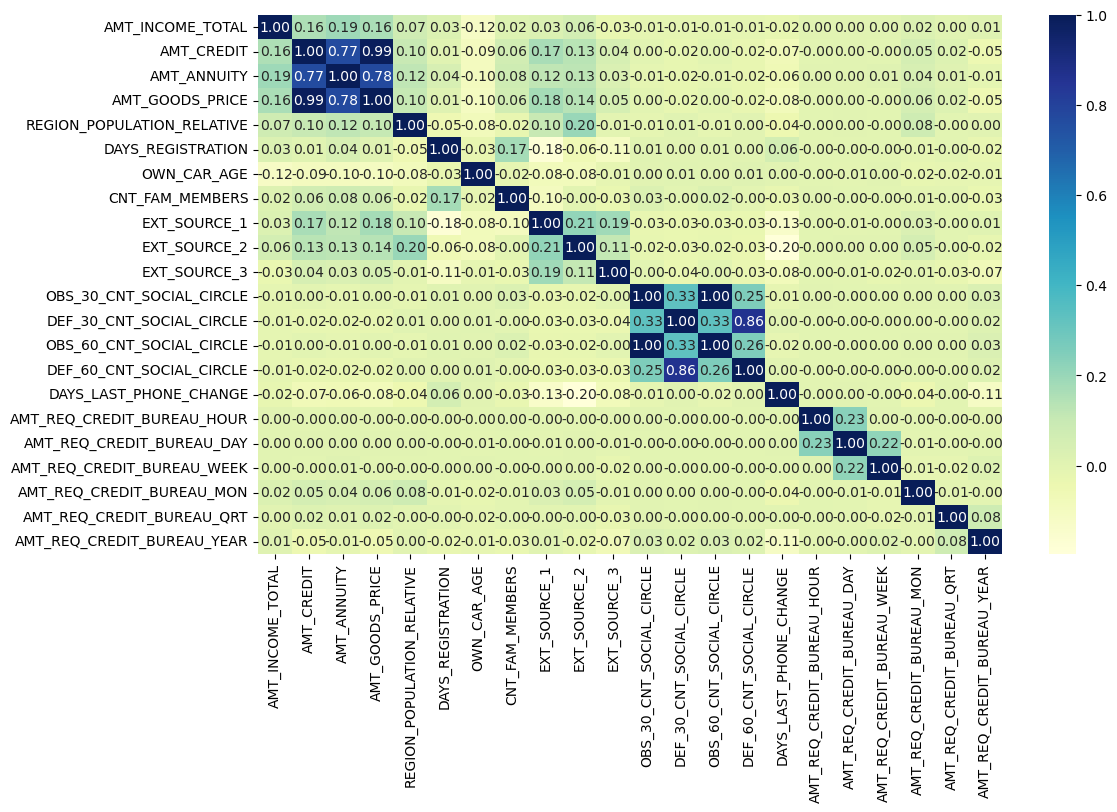

In [23]:
col = datatrain.select_dtypes(include=['float']).columns.tolist()
plt.figure(figsize =(12,7))
sns.heatmap(datatrain[col].corr(),annot = True,fmt='0.2f', cmap = 'YlGnBu')

KORELASI ANTARA DATA FLOAT
1. AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE memiliki korelasi yang tinggi sehingga hanya AMT_CREDIT yang akan dipakai karena tidak memiliki nilai null.
2. OBS_30_CNT_SOCIAL_CIRCLE dan OBS_60_CNT_SOCIAL_CIRCLE memiliki korelasi yang tinggi sehingga salah satu fitur saja yang akan digunakan
3. DEF_30_CNT_SOCIAL_CIRCLE dan DEF_60_CNT_SOCIAL_CIRCLE memiliki korelasi yang tinggi sehingga salah satu fitur saja yang akan digunakan

In [24]:
datatrain.select_dtypes(include=['object']).nunique()

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
dtype: int64

I. Fitur-fitur jenis float

In [25]:
datatrain.select_dtypes(include=['float']).columns.tolist()

['AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_REGISTRATION',
 'OWN_CAR_AGE',
 'CNT_FAM_MEMBERS',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR']

In [26]:
def uni_flt(data,col):
  f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (0.1, 0.8)}, figsize=(10,5))
  sns.boxplot(data[col], ax=ax_box, showmeans=True)
  sns.distplot(data[col], ax=ax_hist)
  plt.show()

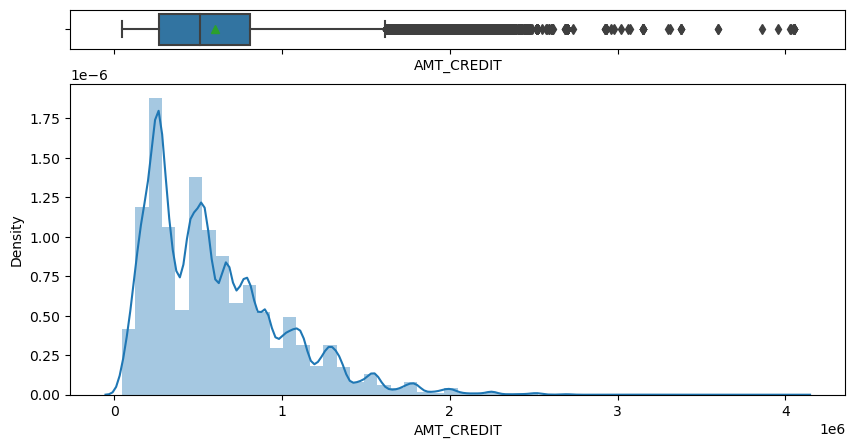

In [27]:
uni_flt(datatrain,'AMT_CREDIT')

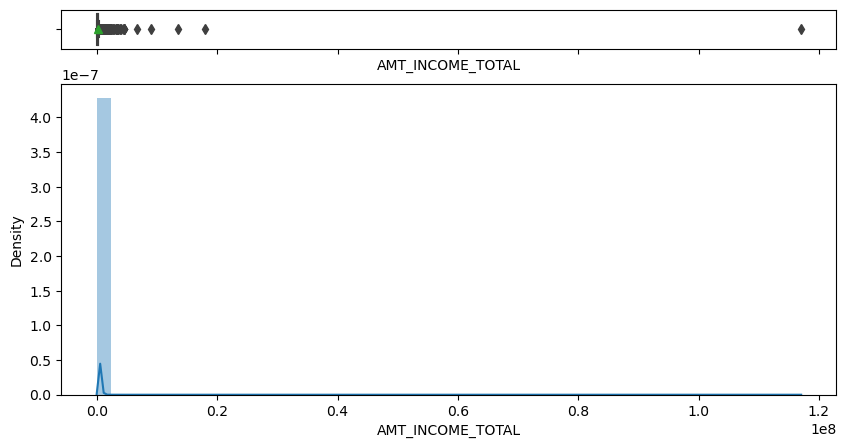

count    3.075110e+05
mean     1.687979e+05
std      2.371231e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.471500e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64

In [28]:
uni_flt(datatrain, 'AMT_INCOME_TOTAL')
datatrain['AMT_INCOME_TOTAL'].describe()

- Outlier variabel ini sangat banyak, distribusinya sedikit skew kanan
- Nilai maksimal dibanding minimalnya berjarak sangat jauh, tetapi wajar karena income setiap individu bisa bervariasi

II. Fitur-fitur jenis object

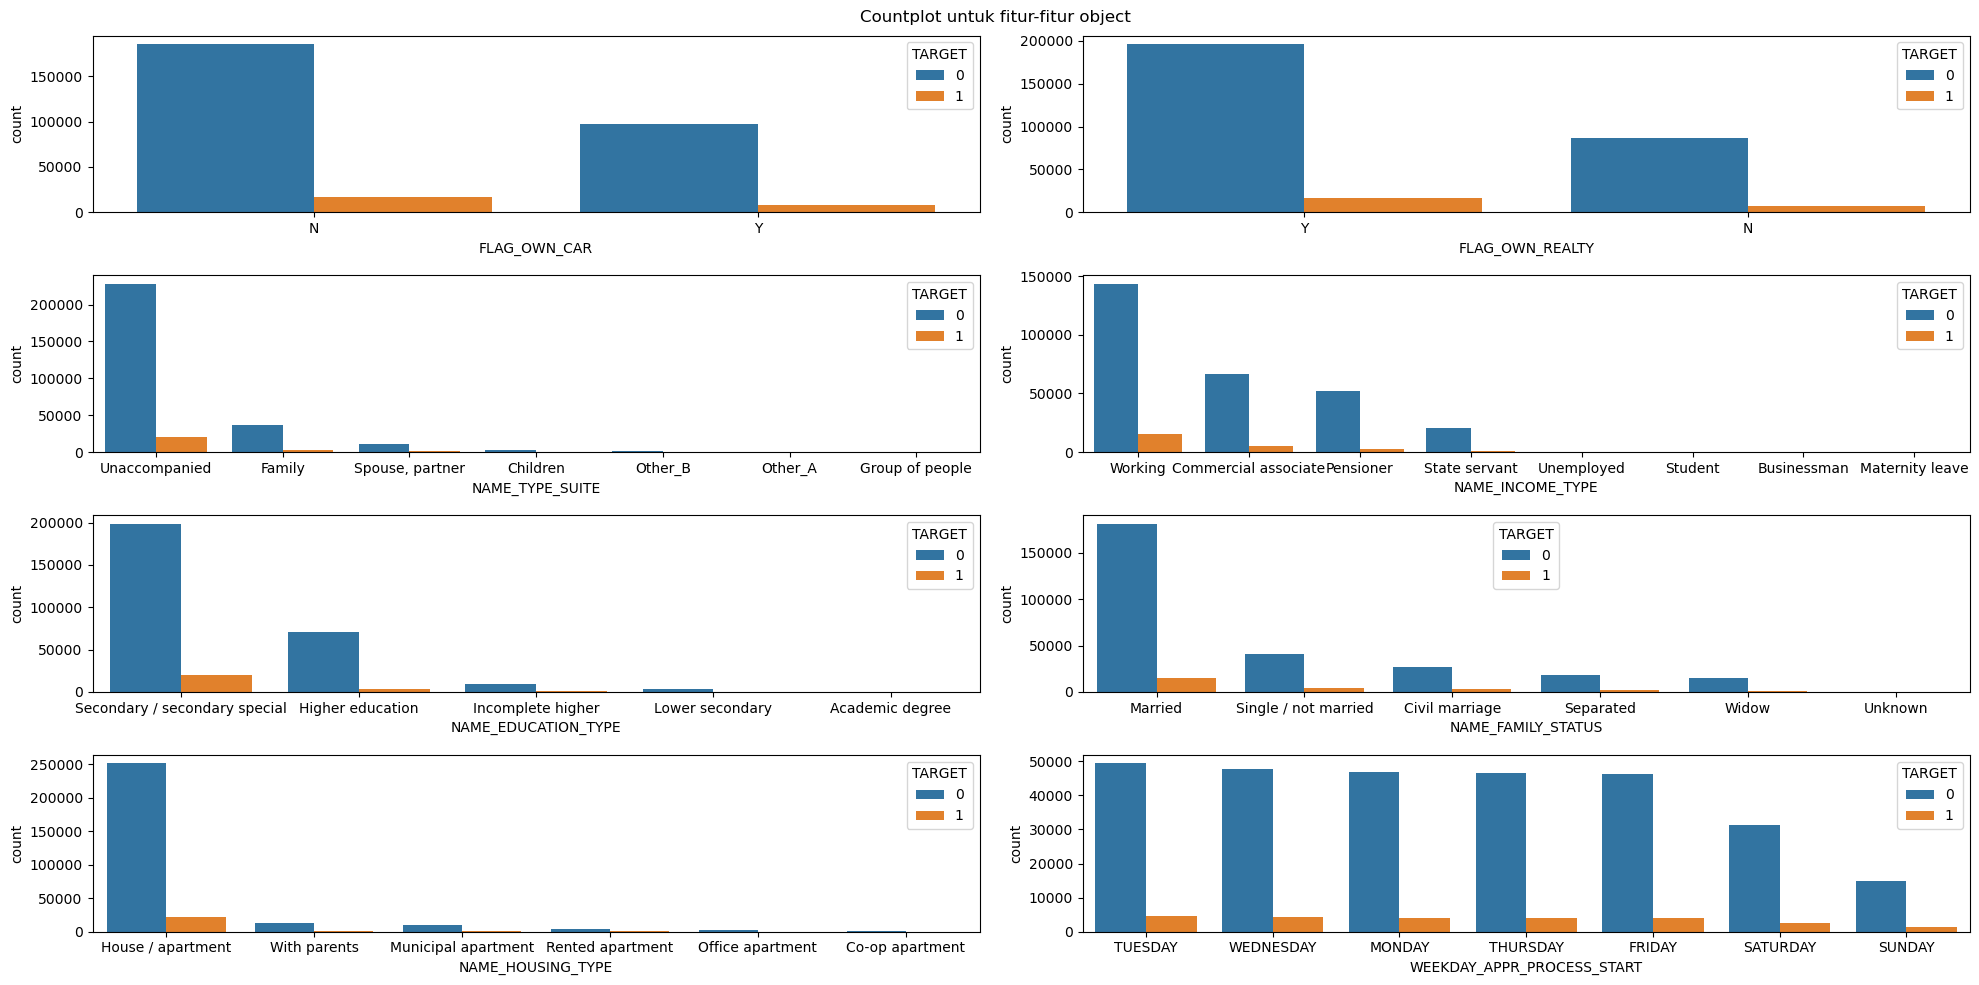

In [29]:
fig,axes = plt.subplots(4,2,figsize =(20,10))
fig.suptitle('Countplot untuk fitur-fitur object')
sns.countplot(ax = axes[0,0], x = 'FLAG_OWN_CAR',data = datatrain,hue ='TARGET' ,order = datatrain['FLAG_OWN_CAR'].value_counts().index);
sns.countplot(ax = axes[0,1], x = 'FLAG_OWN_REALTY',data = datatrain,hue ='TARGET' , order = datatrain['FLAG_OWN_REALTY'].value_counts().index);
sns.countplot(ax = axes[1,0], x = 'NAME_TYPE_SUITE',data = datatrain,hue ='TARGET' , order = datatrain['NAME_TYPE_SUITE'].value_counts().index);
sns.countplot(ax = axes[1,1], x = 'NAME_INCOME_TYPE',data = datatrain,hue ='TARGET' , order = datatrain['NAME_INCOME_TYPE'].value_counts().index);
sns.countplot(ax = axes[2,0], x = 'NAME_EDUCATION_TYPE',data = datatrain,hue ='TARGET' , order = datatrain['NAME_EDUCATION_TYPE'].value_counts().index);
sns.countplot(ax = axes[2,1], x = 'NAME_FAMILY_STATUS',data = datatrain,hue ='TARGET' , order = datatrain['NAME_FAMILY_STATUS'].value_counts().index);
sns.countplot(ax = axes[3,0], x = 'NAME_HOUSING_TYPE',data = datatrain,hue ='TARGET' , order = datatrain['NAME_HOUSING_TYPE'].value_counts().index);
sns.countplot(ax = axes[3,1], x = 'WEEKDAY_APPR_PROCESS_START',data = datatrain,hue ='TARGET' , order = datatrain['WEEKDAY_APPR_PROCESS_START'].value_counts().index);

plt.tight_layout() 

- Pelanggan yang tidak memiliki masalah membayar (TARGET = 0) selalu lebih banyak pada setiap grafik diatas.
- Pengguna credit paling banyak adalah yang tidak memiliki mobil. Akan tetapi lebih banyak pengguna credit yang memiliki rumah dibanding tidak memiliki. 
- Pengguna credit paling banyak adalah yang sudah menikah
- Dari segi pendidikan terakhir, pengguna credit paling banyak adalah individu dengan pendidikan berkelanjutan.
- Banyak individu yang mengajukan kredit tanpa ditemani keluarga, pasangannya, atau lainnya.
- Jenis tempat tinggal paling umum dari seluruh pengguna kredit adalah rumah/ apartemen pribadi, kedua adalah tinggal dengan orang tua, ketiga adalah apartemen pemerintah atau rumah susun.


In [30]:
datatrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   TARGET                       307511 non-null  int64  
 1   NAME_CONTRACT_TYPE           307511 non-null  object 
 2   CODE_GENDER                  307511 non-null  object 
 3   FLAG_OWN_CAR                 307511 non-null  object 
 4   FLAG_OWN_REALTY              307511 non-null  object 
 5   CNT_CHILDREN                 307511 non-null  int64  
 6   AMT_INCOME_TOTAL             307511 non-null  float64
 7   AMT_CREDIT                   307511 non-null  float64
 8   AMT_ANNUITY                  307499 non-null  float64
 9   AMT_GOODS_PRICE              307233 non-null  float64
 10  NAME_TYPE_SUITE              306219 non-null  object 
 11  NAME_INCOME_TYPE             307511 non-null  object 
 12  NAME_EDUCATION_TYPE          307511 non-null  object 
 13 

III. Fitur-Fitur jenis integer

In [31]:
datatrain.select_dtypes(include=['integer']).columns.tolist()

['TARGET',
 'CNT_CHILDREN',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_ID_PUBLISH',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21']

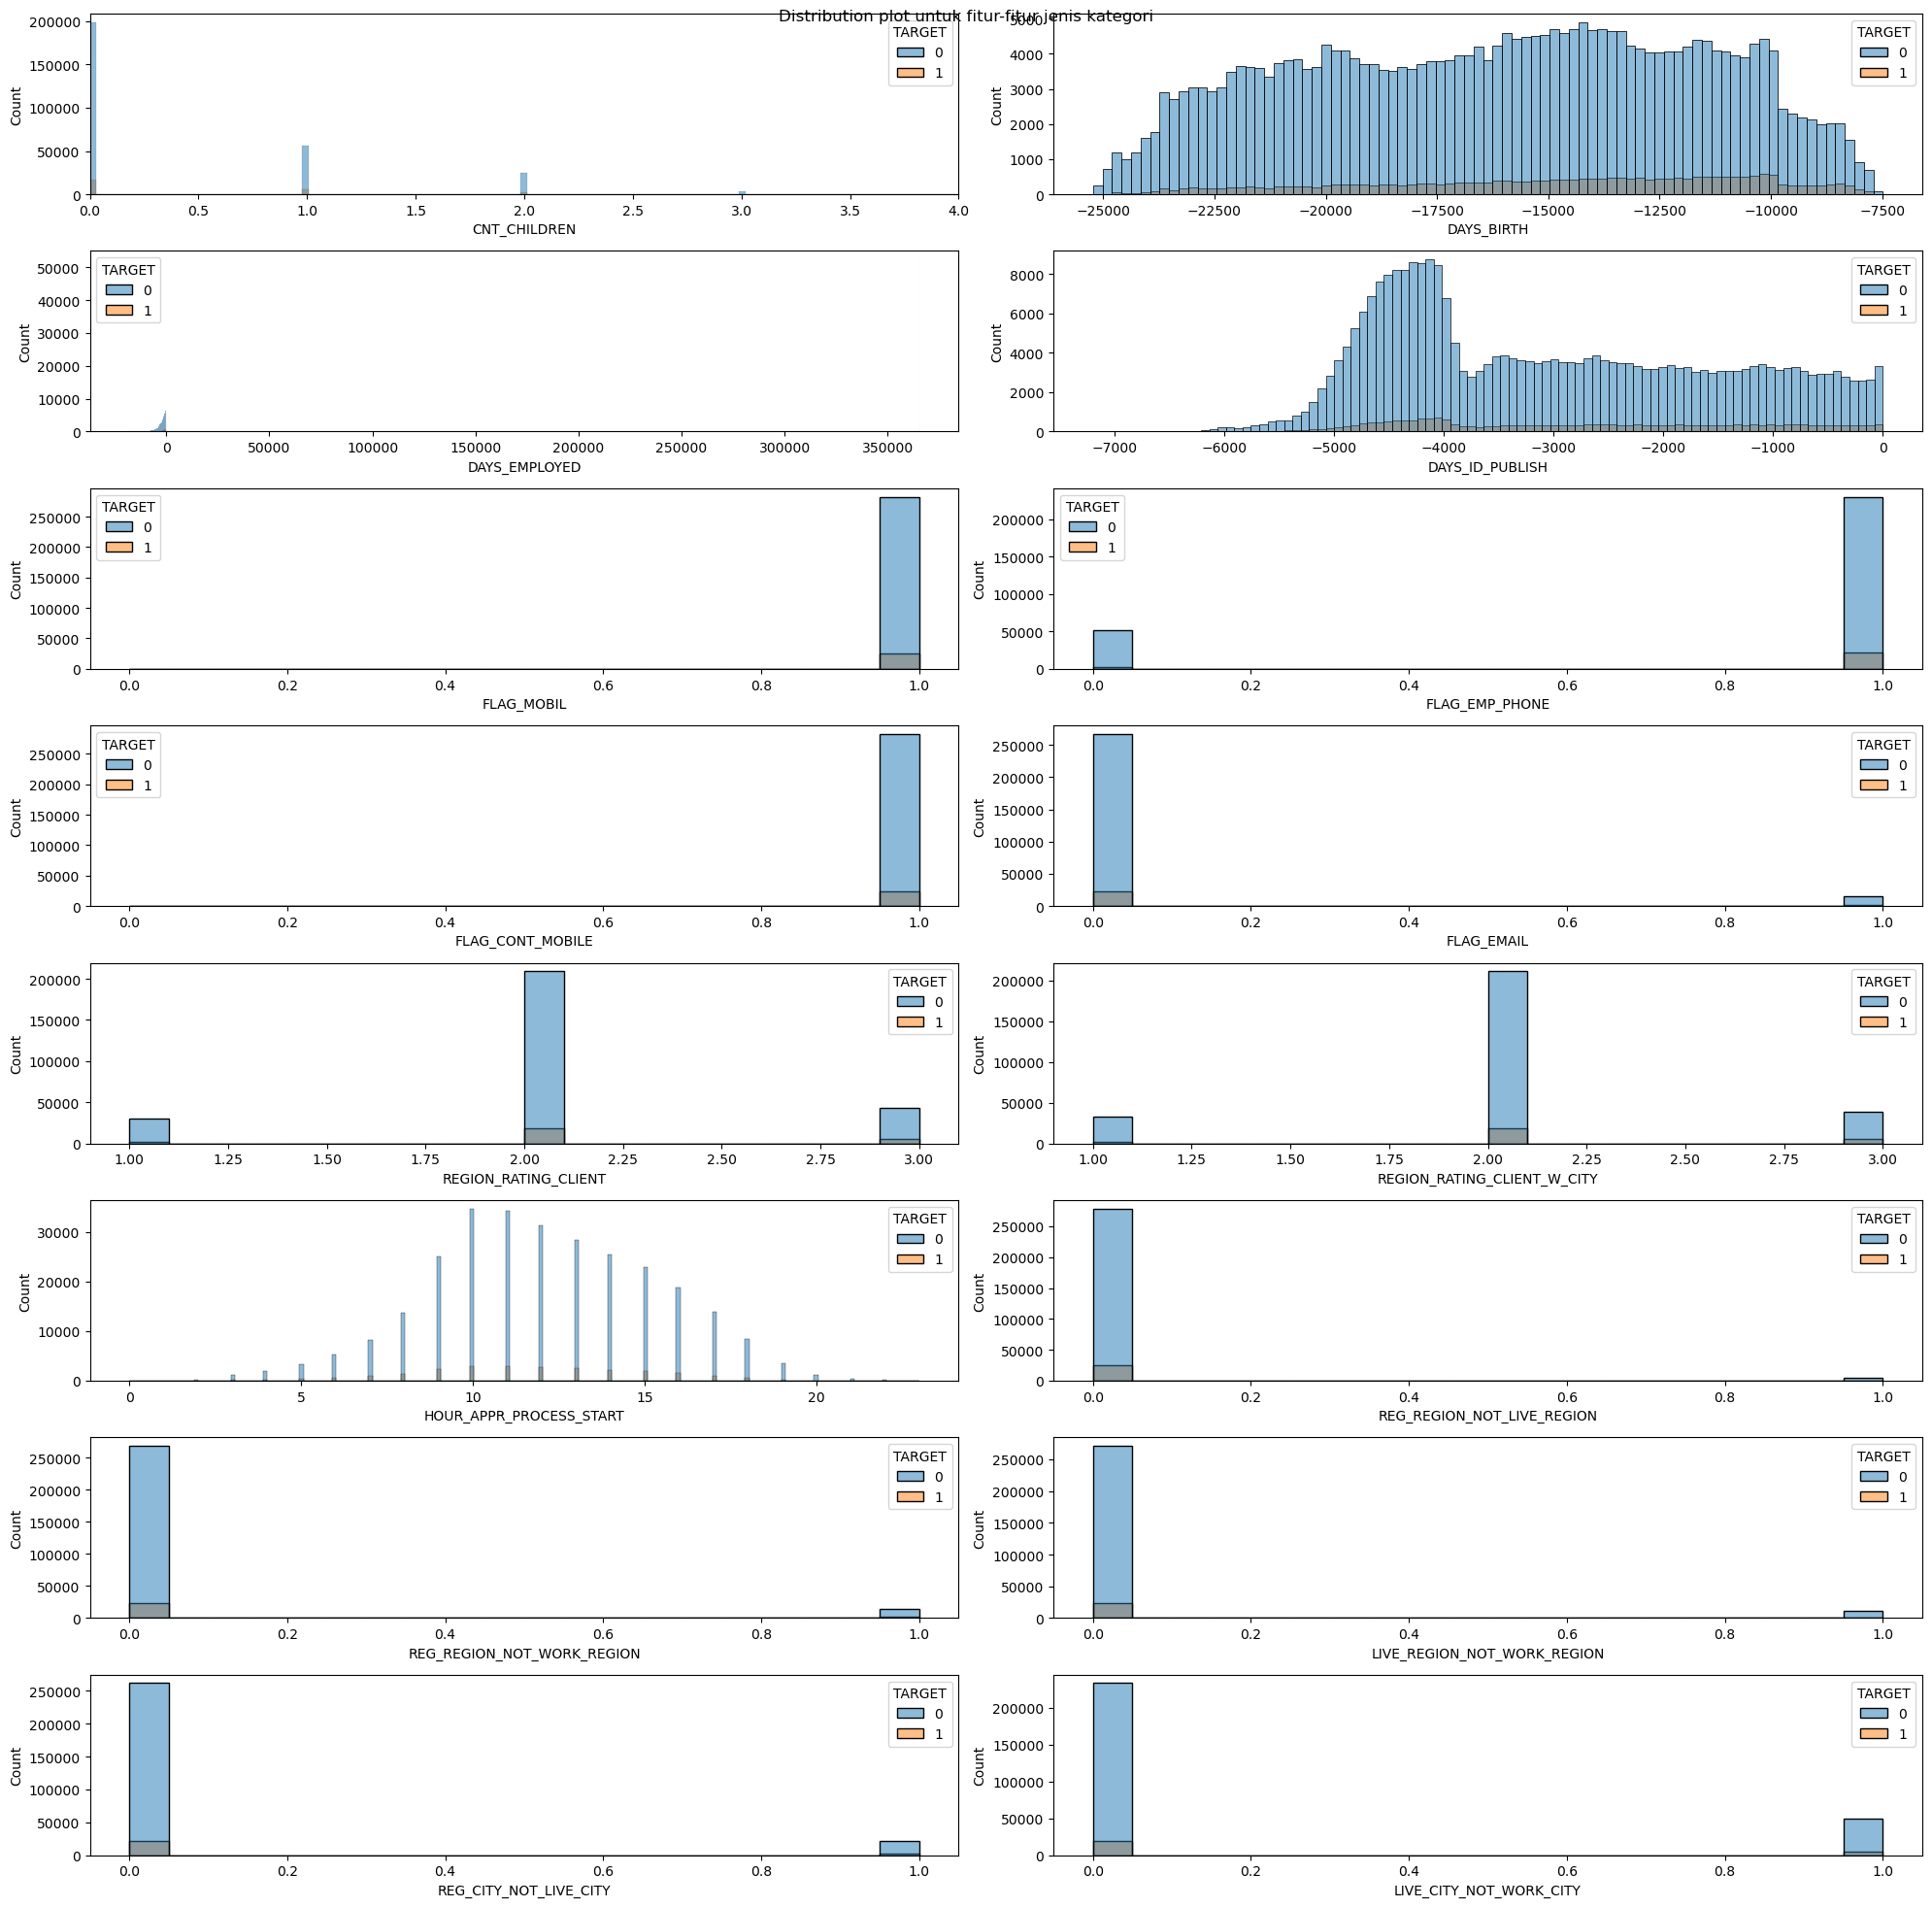

In [32]:
fig,axes = plt.subplots(8,2,figsize =(20,20))

fig.suptitle('Distribution plot untuk fitur-fitur jenis kategori')
ch = sns.histplot(data=datatrain,x='CNT_CHILDREN',hue='TARGET',ax = axes[0,0])
ch.set(xlim=(0,4.0));
sns.histplot(data=datatrain,x= 'DAYS_BIRTH',hue='TARGET',ax = axes[0,1]);
sns.histplot(data=datatrain,x='DAYS_EMPLOYED',hue='TARGET',ax = axes[1,0]);
sns.histplot(data=datatrain,x='DAYS_ID_PUBLISH',hue='TARGET',ax = axes[1,1]);
sns.histplot(data=datatrain,x='FLAG_MOBIL',hue='TARGET',ax = axes[2,0]);
sns.histplot(data=datatrain,x='FLAG_EMP_PHONE',hue='TARGET',ax = axes[2,1]);
sns.histplot(data=datatrain,x='FLAG_CONT_MOBILE',hue='TARGET',ax = axes[3,0]);
sns.histplot(data=datatrain,x='FLAG_EMAIL',hue='TARGET',ax = axes[3,1]);
sns.histplot(data=datatrain,x='REGION_RATING_CLIENT',hue='TARGET',ax = axes[4,0]);
sns.histplot(data=datatrain,x='REGION_RATING_CLIENT_W_CITY',hue='TARGET',ax = axes[4,1]);
sns.histplot(data=datatrain,x='HOUR_APPR_PROCESS_START',hue='TARGET',ax = axes[5,0]);
sns.histplot(data=datatrain,x='REG_REGION_NOT_LIVE_REGION',hue='TARGET',ax = axes[5,1]);
sns.histplot(data=datatrain,x='REG_REGION_NOT_WORK_REGION',hue='TARGET',ax = axes[6,0]);
sns.histplot(data=datatrain,x='LIVE_REGION_NOT_WORK_REGION',hue='TARGET',ax = axes[6,1]);
sns.histplot(data=datatrain,x='REG_CITY_NOT_LIVE_CITY',hue='TARGET',ax = axes[7,0]);
sns.histplot(data=datatrain,x='LIVE_CITY_NOT_WORK_CITY',hue='TARGET',ax = axes[7,1]);
plt.tight_layout()

- DAYS_ID_PUBLISH, DAYS_BIRTH, dan HOUR_APPR_PROCESS_START akan dihapus

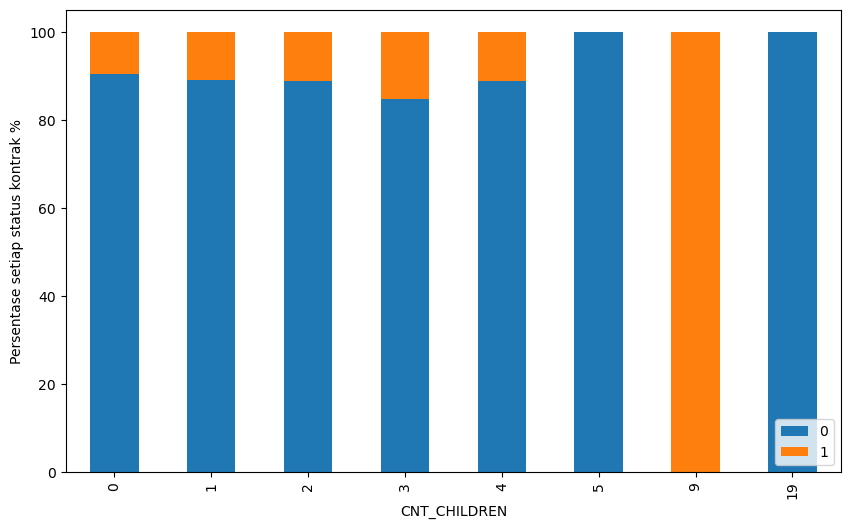

In [33]:
datat = datatrain.loc[datatrain['NAME_FAMILY_STATUS'] == 'Single / not married']
stacked_barplot(datat, 'CNT_CHILDREN', 'TARGET')

Text(0.5, 1.0, 'Jumlah anak dari setiap pengguna kredit yang belum menikah')

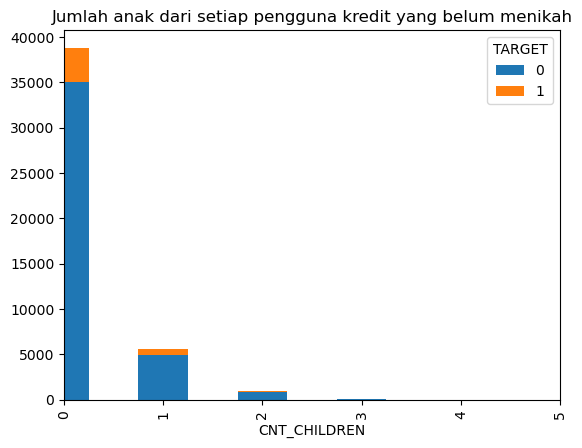

In [34]:
plt1 = pd.crosstab(datat.CNT_CHILDREN,datatrain.TARGET)
plt1.plot(kind='bar',stacked=True)
plt.xlim(0,5)
plt.title('Jumlah anak dari setiap pengguna kredit yang belum menikah')

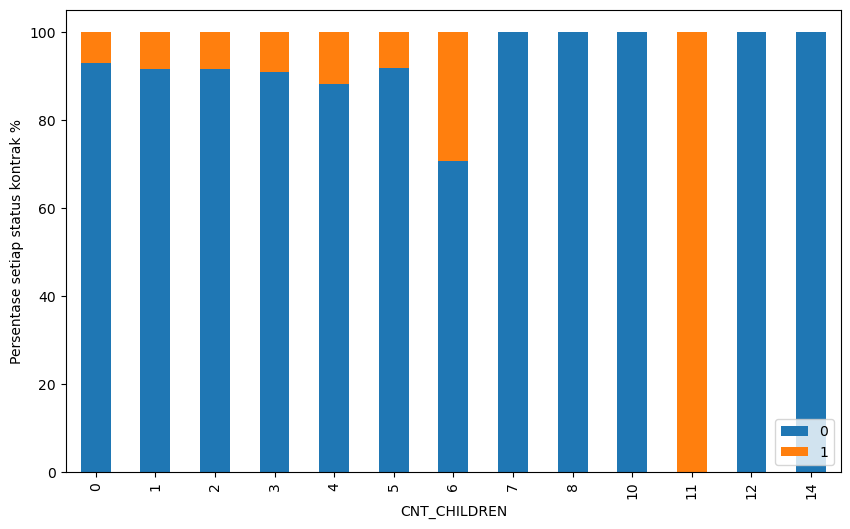

In [35]:
datam = datatrain.loc[datatrain['NAME_FAMILY_STATUS'] == 'Married']
stacked_barplot(datam, 'CNT_CHILDREN', 'TARGET')

Text(0.5, 1.0, 'Jumlah anak dari setiap pengguna kredit yang sudah menikah')

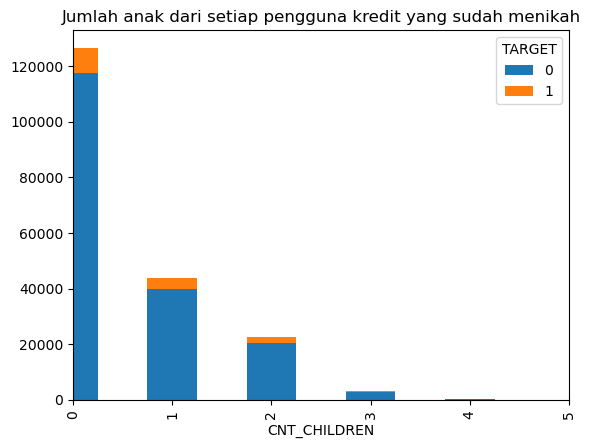

In [36]:
plt1 = pd.crosstab(datam.CNT_CHILDREN,datatrain.TARGET)
plt1.plot(kind='bar',stacked=True)
plt.xlim(0,5)
plt.title('Jumlah anak dari setiap pengguna kredit yang sudah menikah')

Text(0.5, 1.0, 'Umur Pengguna Kredit')

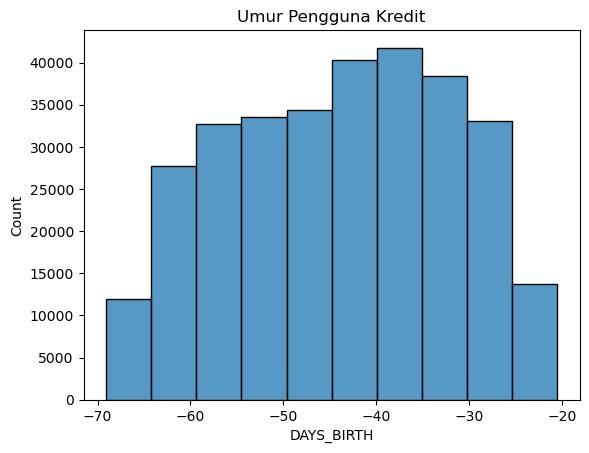

In [37]:
sns.histplot(datatrain['DAYS_BIRTH']/365.25, bins=10)
plt.title('Umur Pengguna Kredit')

In [38]:
datatrain.isnull().sum()

TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
FLAG_OWN_REALTY                   0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 74, dtype: int64

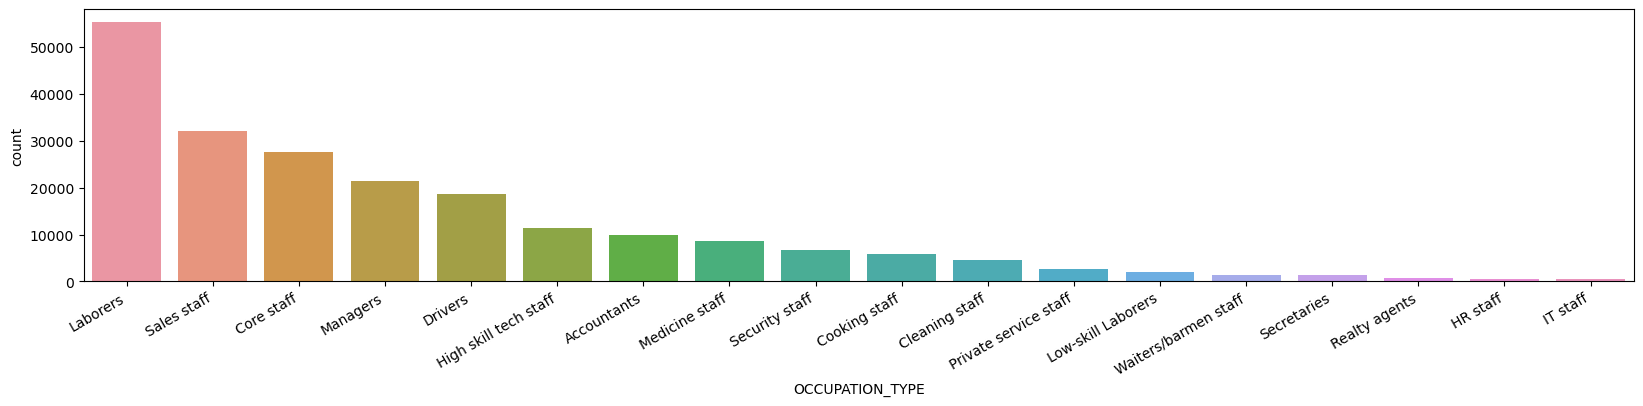

In [39]:
fig, ax = plt.subplots(figsize=(20, 4))
sns.countplot(data = datatrain, x = 'OCCUPATION_TYPE',order = datatrain['OCCUPATION_TYPE'].value_counts().index)
fig.autofmt_xdate()

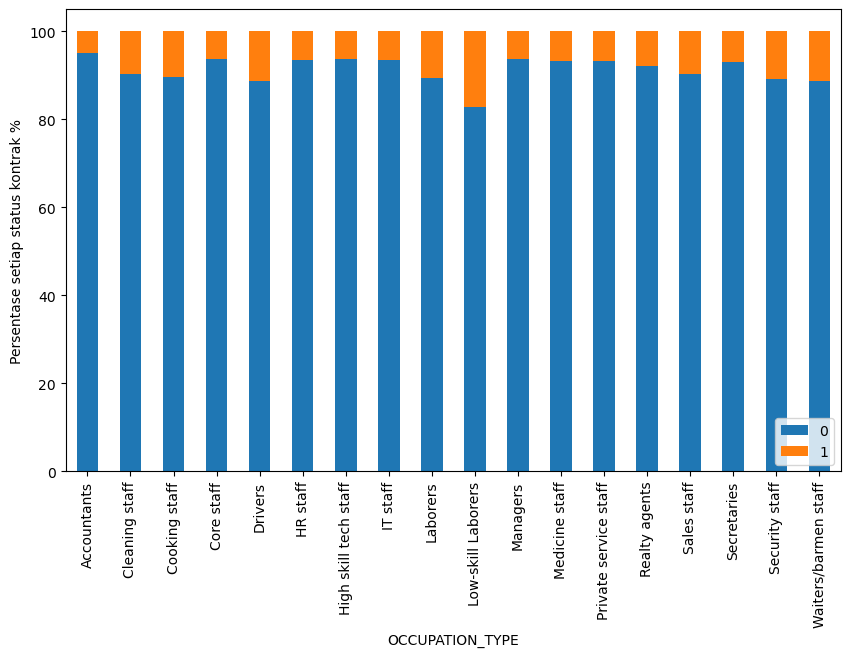

In [40]:
stacked_barplot(datatrain, 'OCCUPATION_TYPE', 'TARGET')

In [41]:
datatrain.describe().T

,count,mean,std,min,25%,50%,75%,max
TARGET,307511.0,0.080729,0.272419,0.0,0.0,0.0,0.0,1.0
CNT_CHILDREN,307511.0,0.417052,0.722121,0.0,0.0,0.0,1.0,19.0
AMT_INCOME_TOTAL,307511.0,168797.919297,237123.146279,25650.0,112500.0,147150.0,202500.0,117000000.0
AMT_CREDIT,307511.0,599025.999706,402490.776996,45000.0,270000.0,513531.0,808650.0,4050000.0
AMT_ANNUITY,307499.0,27108.573909,14493.737315,1615.5,16524.0,24903.0,34596.0,258025.5
...,...,...,...,...,...,...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,265992.0,0.007000,0.110757,0.0,0.0,0.0,0.0,9.0
AMT_REQ_CREDIT_BUREAU_WEEK,265992.0,0.034362,0.204685,0.0,0.0,0.0,0.0,8.0
AMT_REQ_CREDIT_BUREAU_MON,265992.0,0.267395,0.916002,0.0,0.0,0.0,0.0,27.0
AMT_REQ_CREDIT_BUREAU_QRT,265992.0,0.265474,0.794056,0.0,0.0,0.0,0.0,261.0


Berdasarkan percentile 50% dan rata-rata setiap fitur:
- EXT_SOURCE_2 memiliki distribusi relatif normal
- EXT_SOURCE_3 memiliki distribusi relatif normal
- OBS_30_CNT_SOCIAL_CIRCLE memiliki distribusi skew kanan        
- DEF_30_CNT_SOCIAL_CIRCLE memiliki distribusi skew kanan       
- OBS_60_CNT_SOCIAL_CIRCLE memiliki distribusi skew kanan       
- DEF_60_CNT_SOCIAL_CIRCLE memiliki distribusi skew kanan 
- AMT_REQ_CREDIT_BUREAU_HOUR memiliki distribusi relatif normal    
- AMT_REQ_CREDIT_BUREAU_DAY memiliki distribusi relatif normal     
- AMT_REQ_CREDIT_BUREAU_WEEK memiliki distribusi relatif normal
- AMT_REQ_CREDIT_BUREAU_QRT memiliki distribusi skew kanan
- AMT_REQ_CREDIT_BUREAU_MON memiliki distribusi skew kanan     
- AMT_REQ_CREDIT_BUREAU_YEAR memiliki distribusi skew kanan    

DATA PREPARATION


Menghapus variabel-variabel yang tidak diperlukan

In [42]:
dropping=['OBS_30_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE','AMT_REQ_CREDIT_BUREAU_HOUR',
          'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK','OCCUPATION_TYPE',
          'FLAG_DOCUMENT_2','FLAG_DOCUMENT_4','FLAG_DOCUMENT_7','FLAG_DOCUMENT_9',
            'FLAG_DOCUMENT_10','FLAG_DOCUMENT_11','FLAG_DOCUMENT_12','FLAG_DOCUMENT_13',
          'FLAG_DOCUMENT_14','FLAG_DOCUMENT_15','FLAG_DOCUMENT_16','FLAG_DOCUMENT_17','FLAG_DOCUMENT_18',
          'FLAG_DOCUMENT_19','FLAG_DOCUMENT_20','FLAG_DOCUMENT_21','ORGANIZATION_TYPE', 'FLAG_CONT_MOBILE','FLAG_MOBIL',
         'DAYS_BIRTH','DAYS_ID_PUBLISH','HOUR_APPR_PROCESS_START','WEEKDAY_APPR_PROCESS_START','AMT_ANNUITY',
          'AMT_GOODS_PRICE', 'OWN_CAR_AGE','EXT_SOURCE_1']
datatrain = datatrain.drop(dropping,axis =1)
datatest = datatest.drop(dropping,axis =1)

MENGISI MISSING VALUES DENGAN MEAN ATAU MEDIAN
- Mean untuk data distribusi normal, median untuk data distribusi skewed

In [43]:
datatrain['EXT_SOURCE_2'].fillna(value =datatrain['EXT_SOURCE_2'].mean(), inplace = True)
datatest['EXT_SOURCE_2'].fillna(value =datatest['EXT_SOURCE_2'].mean(), inplace = True)

datatrain['EXT_SOURCE_3'].fillna(value =datatrain['EXT_SOURCE_3'].mean(), inplace = True)
datatest['EXT_SOURCE_3'].fillna(value =datatest['EXT_SOURCE_3'].mean(), inplace = True)


Menghapus Kode Gender XNA

In [44]:
datatrain.drop(datatrain[datatrain['CODE_GENDER']=='XNA'].index, inplace=True)

In [45]:
datatest.drop(datatest[datatest['CODE_GENDER']=='XNA'].index, inplace=True)

Mengganti data negatif menjadi positif

In [46]:
drops = ['DAYS_LAST_PHONE_CHANGE','DAYS_REGISTRATION','DAYS_LAST_PHONE_CHANGE','DAYS_REGISTRATION',
         'AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_YEAR','AMT_REQ_CREDIT_BUREAU_QRT']
datatrain=datatrain.drop(drops,axis =1)
datatest=datatest.drop(drops,axis =1)

In [47]:
datatrain['DAYS_EMPLOYED']=datatrain['DAYS_EMPLOYED'].abs()
datatest['DAYS_EMPLOYED']=datatest['DAYS_EMPLOYED'].abs()

In [48]:
datatrain = datatrain.dropna(axis=0)
datatest = datatest.dropna(axis=0)

Melakukan Oversampling untuk menyamakan ukuran data target 0 dan 1

In [49]:
 pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


OVERSAMPLING

In [50]:
X= datatrain.drop(['TARGET'],axis=1)
y = datatrain['TARGET']
print(Counter(y))
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(X, y)
print(Counter(y_over))

Counter({0: 280475, 1: 24719})
Counter({1: 280475, 0: 280475})


In [51]:
X=X_over
Y=y_over
X =pd.get_dummies(X,drop_first = True)
select = SelectKBest(score_func =chi2,k=8)
X_tr_new = select.fit_transform(X,Y)

In [52]:
Xtrnew= X.iloc[:,select.get_support()]
feature = Xtrnew.columns.tolist()
X =pd.get_dummies(X, drop_first =True)
X =X[feature]
Y = y_over

In [53]:
X_train, X_test, Y_train,Y_test = train_test_split(X,Y,test_size =0.30,stratify = Y, random_state=1)

In [54]:
print("Shape of Training set : ", X_train.shape)
print("Shape of test set : ", X_test.shape)
print("Percentage of classes in training set:")
print(Y_train.value_counts(normalize=True))
print("Percentage of classes in test set:")
print(Y_test.value_counts(normalize=True))

Shape of Training set :  (392665, 8)
Shape of test set :  (168285, 8)
Percentage of classes in training set:
0    0.500001
1    0.499999
Name: TARGET, dtype: float64
Percentage of classes in test set:
1    0.500003
0    0.499997
Name: TARGET, dtype: float64


LOGISTIC REGRESSION

In [55]:
lg = LogisticRegression(max_iter=3000)
lg.fit(X_train,Y_train)

LogisticRegression(max_iter=3000)

In [56]:
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))

    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Not Cancelled', 'Cancelled'], yticklabels=['Not Cancelled', 'Cancelled'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

              precision    recall  f1-score   support

           0       0.52      0.62      0.56    196333
           1       0.53      0.43      0.47    196332

    accuracy                           0.52    392665
   macro avg       0.52      0.52      0.52    392665
weighted avg       0.52      0.52      0.52    392665



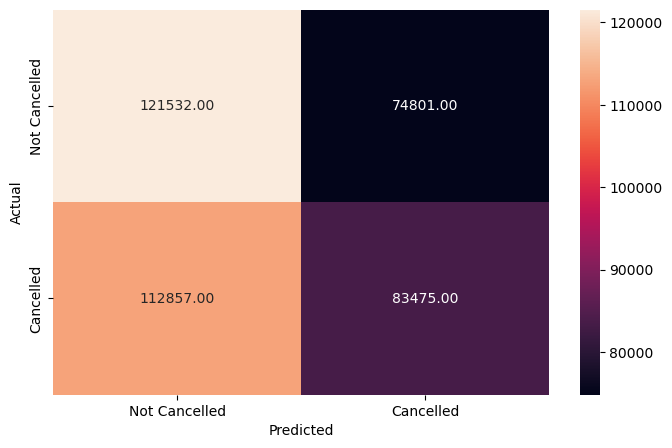

In [57]:
y_pred_train = lg.predict(X_train)
metrics_score(Y_train,y_pred_train) 

              precision    recall  f1-score   support

           0       0.52      0.62      0.56     84142
           1       0.53      0.43      0.47     84143

    accuracy                           0.52    168285
   macro avg       0.52      0.52      0.52    168285
weighted avg       0.52      0.52      0.52    168285



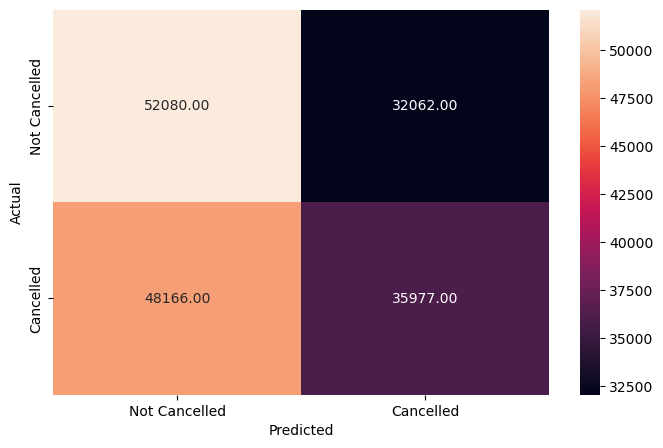

In [58]:
y_pred_test = lg.predict(X_test)
metrics_score(Y_test, y_pred_test)


DECISION TREE

In [59]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train,Y_train)

DecisionTreeClassifier()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    196333
           1       1.00      1.00      1.00    196332

    accuracy                           1.00    392665
   macro avg       1.00      1.00      1.00    392665
weighted avg       1.00      1.00      1.00    392665



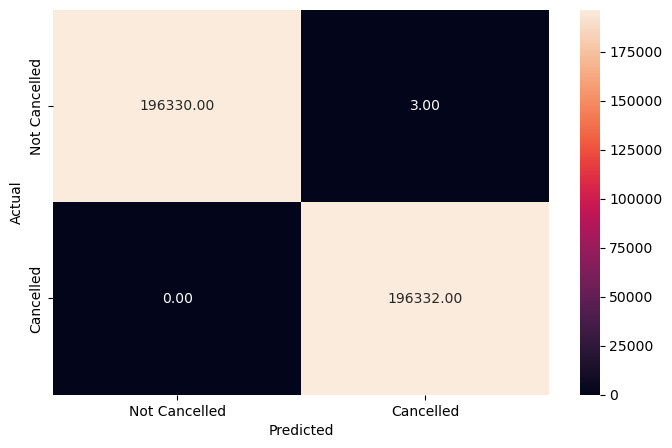

In [60]:
pred_train_dt = model_dt.predict(X_train)
metrics_score(Y_train, pred_train_dt)

              precision    recall  f1-score   support

           0       1.00      0.89      0.94     84142
           1       0.90      1.00      0.95     84143

    accuracy                           0.95    168285
   macro avg       0.95      0.95      0.95    168285
weighted avg       0.95      0.95      0.95    168285



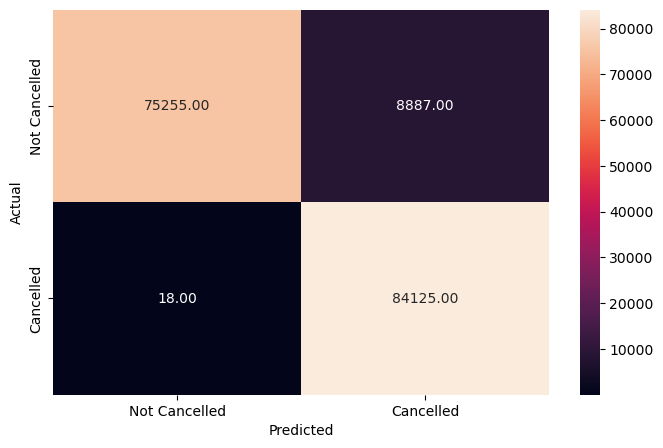

In [61]:
pred_test_dt = model_dt.predict(X_test)
metrics_score(Y_test, pred_test_dt)